# Hierarchical Bayesian Model for Heading Dynamics

This notebook demonstrates the full workflow for fitting the hierarchical Bayesian model to estimate heading dynamics parameters.

**Model equation:**  
$$\hat{\theta}'(t) = \theta_0 + \alpha \cdot \Omega(t) + \gamma \cdot t$$

where:
- $\hat{\theta}'(t)$: Predicted decoded heading
- $\theta_0$: Initial heading (trial-specific)
- $\alpha$: Gain parameter (animal-specific)
- $\Omega(t) = \int_0^t \omega(\tau) d\tau$: Integrated angular velocity
- $\gamma$: Drift parameter (trial-specific)

**Updates (2025):**
- Model now uses **continuous time series** (no speed filtering) to avoid temporal discontinuities
- **Speed-dependent observation noise** automatically down-weights low-speed periods
- New parameter: $\beta_{speed}$ quantifies how observation uncertainty depends on speed
- Expected improvements: Higher R², α closer to 1.0, interpretable parameters

## Setup

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Add parent directory to path
import sys
sys.path.append('../..')

# Import heading model modules
from heading_model import data_preprocessing as dp
from heading_model import bayesian_model as bm
from heading_model import visualization as viz
from heading_model import condition_analysis as ca
from heading_model import utils

# Plotting settings
plt.style.use('default')
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['figure.dpi'] = 100

%matplotlib inline

## Step 1: Load and Preprocess Data

Load the reconstruction dataframe and filter for a specific condition.

In [6]:
# Load data for a single condition
print("Loading and filtering data...")
df = dp.load_and_filter_data(
    conditions=['all_light'],  # Start with light condition
    sessions=dp.DEFAULT_USEABLE_SESSIONS,  # Use all useable sessions
    min_speed=1.,  # Speed threshold (not used for filtering in 'none' mode)
    filter_mode='remove',  # NEW: Keep all data for continuous model
    verbose=True
)

print(f"\nDataframe shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")

Loading and filtering data...
Loading data from: E:\GitHub\Peng_et.al_2025_noInt\Peng\results\reconstuctionDFAutoPI.csv
Loaded 6,617,357 rows
After session filter: 3,165,541 rows from 24 sessions
After condition filter: 312,538 rows
After speed filter (>=1.0 cm/s): 309,141 rows
Removed 0 trials with >20% NaN values
Final dataset: 309,141 rows, 1563 trials, 7 animals

Dataframe shape: (309141, 40)

Columns: ['index', 'mouse', 'session', 'condition', 'trial', 'trialNo', 'xPose', 'yPose', 'hdPose', 'x', 'y', 'px', 'py', 'withinPathTime', 'recTime', 'speed', 'distance', 'v0_cos', 'v0_sin', 'v1_cos', 'v1_sin', 'lv0_cos', 'lv0_sin', 'lv1_cos', 'lv1_sin', 'mvtDirError', 'absMvtDirError', 'shortCondition', 'light', 'path', 'v0_cos_smooth', 'v0_sin_smooth', 'v1_cos_smooth', 'v1_sin_smooth', 'lv0_cos_smooth', 'lv0_sin_smooth', 'lv1_cos_smooth', 'lv1_sin_smooth', 'pSpeed', 'session_trial']


## Step 2: Structure Data for Hierarchical Model

Organize data by animal → trial → timepoints, and compute all required quantities:
- True heading from position
- Angular velocity $\omega(t)$
- Integrated angular velocity $\Omega(t)$
- Decoded heading from predictions

In [7]:
# Structure hierarchical data
print("Structuring hierarchical data...")
data_dict = dp.structure_hierarchical_data(
    df,
    smooth_sigma=1.0,  # Gaussian smoothing for angular velocity
    min_trial_length=50,  # Minimum 50 timepoints per trial
    max_animals=3,  # Use all animals (set to 3-5 for testing)
    verbose=True
)

# Get summary
summary = dp.get_data_summary(data_dict)
print("\nData Summary:")
print(summary.to_string(index=False))

Structuring hierarchical data...

Structuring hierarchical data...
Limiting to first 3 animals
  Processing animal: jp1686
  Processing animal: jp3120
  Processing animal: jp3269

Data structure complete:
  Animals: 3
  Total trials: 344
  Total timepoints: 66,178
  Avg trials per animal: 114.7
  Avg timepoints per trial: 192

Data Summary:
animal  n_trials  total_timepoints  mean_trial_length  min_trial_length  max_trial_length
jp1686        64             13402         209.406250                86              1658
jp3120       109             21988         201.724771                84              1196
jp3269       171             30788         180.046784                89               511


## Step 3: Build Hierarchical Model

Specify the PyMC hierarchical model with priors.

In [8]:
# Initialize model
model = bm.HeadingHierarchicalModel(data_dict, condition_name='all_dark')

# Build PyMC model
model.build_model(
    alpha_prior_mean=1.0,  # Expect perfect integration (α ≈ 1)
    alpha_prior_sd=0.5,    # Allow variability
    gamma_prior_sd=0.1,    # Small drift
    theta0_prior_sd=1.0,   # Initial heading variability
    obs_noise_beta=0.1,    # Observation noise
    use_noncentered=False  # Use centered parameterization
)

print("\nModel built successfully!")


Building hierarchical model for: all_dark
  Animals: 3
  Trials: 344
  Preparing vectorized data...
  Total observations: 66178
Model built successfully!

Model built successfully!


## Step 4: Fit Model with MCMC

Sample from the posterior using NUTS (No-U-Turn Sampler).

⚠️ **Note:** This can take 30-60 minutes for full dataset. Start with fewer animals for testing.

In [9]:
# Fit model
trace = model.fit(
    draws=1000,         # Posterior samples per chain
    tune=500,          # Warmup/tuning samples
    chains=4,           # Number of chains (for convergence checking)
    target_accept=0.9, # Target acceptance rate
    cores=4,            # Parallel chains
    # random_seed=42      # For reproducibility
)

print("\nSampling complete!")


Fitting model with MCMC...
  Chains: 4
  Tune: 500, Draws: 1000
  Target accept: 0.9


Initializing NUTS using jitter+adapt_diag...


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'mu_alpha': array(0.10057152), 'sigma_alpha_log__': array(-0.66296972), 'mu_gamma': array(-0.82720918), 'sigma_gamma_log__': array(-1.55809246), 'mu_theta0': array(0.69831326), 'sigma_theta0_log__': array(0.92052379), 'sigma_base_log__': array(-1.88337037), 'beta_speed_log__': array(0.91909408), 'alpha': array([-0.47903024, -0.86093256,  0.56695401]), 'gamma': array([-0.77796662, -0.41584089, -1.31434033, -1.12354386, -0.74017666,
       -1.43318018, -1.58007   , -1.18592666, -1.80932093, -1.48471266,
       -0.72716223, -1.16261088, -0.6493431 , -0.2699122 , -1.11140202,
       -0.29917307, -1.68515092, -1.43762164, -1.20734189, -1.36169377,
       -0.32454276, -1.27137626, -0.00722247, -0.98904277, -0.89071204,
       -0.02109061, -0.84217753, -0.07669121, -0.91243053, -1.1913809 ,
       -1.07718703, -0.52931486, -1.4808973 , -1.51359035, -1.3601613 ,
       -1.73914142, -0.74970315, -1.41978905, -0.99371303, -0.50638608,
       -0.52527927, -0.69271625, -0.99411777, -1.50334036,  0.01058002,
       -1.7936412 , -1.02574788, -1.06961531, -0.63648603, -0.02167147,
       -0.19321483, -0.15764271, -1.53377278, -1.12674279, -0.7716792 ,
       -0.50892628, -1.02134841, -1.7225908 , -1.82684463, -0.40514333,
       -1.72541469, -1.79134492,  0.13271848, -1.76525322, -0.49757704,
        0.03018582, -0.15508256, -1.61178168, -1.38341368, -0.63757222,
       -1.57518163, -1.17784425, -1.73446928,  0.05694532, -1.74296344,
       -0.79576826, -0.51334352, -1.07333097, -1.13557431, -1.55651736,
       -0.49362769, -0.99187293, -0.34701313, -1.37921846, -0.2657169 ,
       -1.55693429, -1.25509239, -1.45126233, -1.51504849, -1.55258563,
       -0.07589125, -0.4571081 , -0.45359122, -1.05044932, -1.37528785,
       -0.74312641, -0.54105338, -0.35193108, -0.34669002, -0.78411748,
       -1.55075157, -1.65557603, -1.58585774, -1.53817369, -0.01121539,
       -1.31252458, -0.82047245, -1.55670028,  0.11520113, -0.59907496,
       -0.22746901, -1.4931404 , -1.41660006,  0.063818  , -0.54010991,
       -0.49072306, -1.74724069, -1.32132651, -0.7009247 , -1.20343173,
       -0.8466461 , -1.6601649 , -0.65459179, -1.63565027, -1.12723211,
       -1.52467637, -1.2056242 , -1.74100482, -1.4554419 ,  0.0488888 ,
       -1.6115367 , -0.74164147, -1.66885141, -0.70688676, -1.3785503 ,
       -1.70087287, -0.4123069 , -0.78228763, -0.73039582, -1.53150707,
       -0.81674899, -0.61183784, -1.39036841,  0.05386131, -0.18016163,
       -0.97041822, -1.51827041,  0.16534844, -1.58741652, -1.30197848,
       -1.7392647 , -1.13811008, -1.59668519, -1.79320678, -0.08955712,
       -1.11491788, -1.81713317, -0.5042766 , -0.72013203, -1.78657861,
       -0.97751066, -1.24481387, -0.09091811, -1.43407598, -1.01501588,
       -0.73176453, -1.67151649, -1.11312295, -1.46453789, -1.80621231,
       -0.59293774, -0.51291243, -1.12881448,  0.12532963, -1.48530547,
       -1.53793533, -1.59501205, -1.30422408, -0.44750275, -0.06781513,
       -0.48077668, -1.05407686, -0.43646856, -0.28996793, -1.21790564,
       -0.02631919, -0.73259304,  0.02488673, -1.51641906, -1.25076948,
       -1.23132812, -0.75998739, -0.53879216, -1.30148423, -0.53091402,
       -0.99073956, -1.50279368, -1.70322318, -1.02804739, -1.39748785,
       -1.19893104, -0.81878622, -1.4973359 , -1.76852177, -0.74080579,
       -0.70007916, -0.46298249, -1.63603027, -1.0259736 , -0.36947136,
       -0.06885221, -0.46542413, -1.35137719, -1.28267314, -1.51780404,
       -1.45677066, -1.6894816 ,  0.01404494, -1.69871614, -1.37243356,
       -0.12559284, -1.07001204, -1.59958061,  0.14087776, -1.15503902,
       -0.32713427,  0.13855457, -0.07692681, -1.81832752, -0.01751096,
       -0.56516161, -0.75515626, -0.81024045,  0.07320309, -0.18715156,
       -0.14336007, -0.89058341, -1.2132379 , -0.08251903,  0.11152682,
        0.03018751, -1.46022842, -0.86184255, -1.39549766, -0.97853399,
       -0.78197271, -1.03442313, -0.55893864, -0.15392344, -0.9148421 ,
       -1.3741149 , -1.81475232, -1.15589952, -0.24826782, -0.54204337,
       -1.07077884, -0.59813468, -0.34880059, -1.49809729, -0.90118039,
       -0.59779037, -0.04920421, -0.02245084, -0.60633976, -0.73386927,
       -0.41267392,  0.02610013,  0.09153446, -0.18528571, -0.46361539,
        0.05908197, -1.20343882, -0.44346856, -1.17824334, -1.66151929,
       -0.98145321, -0.72325397, -1.73961885, -1.58896511, -0.96828932,
       -0.93418299, -1.01811272, -1.6913204 , -1.1280121 , -1.52493275,
       -0.41815318, -1.61431484, -0.08307853, -0.20934104,  0.12698286,
       -0.82306862,  0.04579162,  0.13539701, -1.46431384, -0.64827197,
       -0.90932387, -0.05344692, -1.1906382 , -1.02709549, -0.47002212,
       -1.81145541, -0.4709673 , -0.47457687, -1.58037498,  0.10149109,
       -1.8154679 , -0.87271304, -0.52516073, -0.56284232, -0.28728801,
       -0.38745311, -1.74020293, -1.23119619, -1.80975703, -1.74858413,
       -1.72643422, -1.23191191, -1.42220444, -0.93721127, -0.56441233,
       -1.54687308, -1.03278988, -0.55167308, -1.40859329, -0.30892172,
       -0.77133666, -0.85732874, -0.52442589, -1.39113853, -0.9578381 ,
       -0.25010188, -0.72234859, -0.44159554, -1.50766536, -1.66248111,
       -1.44799876, -1.74642702, -0.57284759, -1.30389459, -0.70814242,
       -0.90795497, -0.67449266, -0.37953601, -1.45272263]), 'theta_0': array([ 1.17674128e+00,  4.02110274e-01,  4.08305436e-04,  1.60166413e+00,
        6.92902640e-01,  1.29077146e+00,  8.04593006e-01, -1.03756828e-02,
       -1.37443336e-01,  9.08357415e-01,  8.23491118e-01,  1.39906562e+00,
        1.60687550e+00,  1.85549298e-01,  4.75182855e-01,  8.70175485e-01,
        1.12197157e+00,  4.57994674e-01,  1.20206712e+00, -1.44082992e-01,
       -2.01399022e-01,  9.24025472e-01,  1.63102233e+00,  1.14821214e+00,
        1.33121345e+00,  6.21882087e-01,  1.23690304e+00,  7.15086175e-01,
        1.20088471e+00,  4.61898496e-01,  9.06916448e-03,  1.42309479e+00,
        1.26141013e+00,  1.45668996e+00,  5.01042203e-01,  1.58809246e+00,
        1.55514628e+00,  7.86673271e-01,  6.70068982e-01,  1.09085787e+00,
        5.66005845e-01,  5.36703818e-01, -7.52073672e-02,  9.04980405e-01,
        8.23095414e-02,  1.18097138e+00,  1.32102850e+00, -1.09250406e-01,
        1.42594910e-01,  1.43812931e-01,  2.67399798e-01,  5.93170127e-02,
        7.54179321e-01,  4.01941890e-01,  1.03686904e+00,  1.01514675e-01,
        3.73135935e-01, -1.00547146e-01, -8.04037263e-02,  2.65541963e-01,
        7.44953057e-01,  1.29449676e+00,  8.98187299e-01,  4.67431911e-01,
       -1.16615388e-01,  1.02999006e+00,  3.02603432e-02, -2.09862252e-01,
        1.44232120e+00,  1.30285877e+00,  1.37814756e+00, -2.15265045e-01,
        1.23626591e+00, -1.55014855e-01,  7.43641077e-01,  4.86342337e-01,
       -9.24309066e-02,  1.07856319e+00, -1.66225525e-01,  5.73768734e-01,
        7.04995070e-01,  1.21771711e+00,  6.83676618e-01,  9.61099956e-01,
        4.96563296e-01,  1.26451017e+00,  2.06883928e-01, -2.08203664e-01,
       -4.06998265e-02,  1.68238661e+00,  1.56453498e+00, -1.40831971e-01,
        1.30884671e+00,  9.21033880e-01,  6.94535262e-01,  1.07263179e+00,
        1.27766331e-01,  1.28409407e+00,  6.56269626e-01,  1.28816412e+00,
        1.46940966e-01,  9.38676648e-02,  7.42908138e-01,  8.45633301e-01,
        1.07975973e-01,  4.27485724e-01,  8.71734250e-01,  9.41033652e-01,
        1.63054811e+00,  6.00450598e-01,  7.56072892e-01,  1.37586923e+00,
        1.20561965e+00,  1.39381231e+00,  1.10372789e+00,  2.08349935e-01,
        1.63775955e+00,  1.45490972e+00,  8.37903186e-01,  7.50389248e-01,
        1.37801130e+00,  7.55765246e-01,  3.08564510e-01,  1.08433310e+00,
        1.33475334e+00,  1.21881255e+00,  3.99095462e-02, -1.51925662e-01,
        5.78415849e-01,  1.33769796e+00,  1.48318546e+00,  1.56219090e+00,
        4.61841550e-01,  4.97157064e-01,  4.52109416e-01,  8.65240723e-01,
        1.47974378e+00,  8.43152217e-01,  1.64397289e+00,  1.29042184e+00,
        1.86235122e-01,  1.22143334e+00,  1.22673540e+00,  1.11853715e+00,
        3.15634854e-01,  6.24307359e-01,  2.65605271e-01,  4.29530498e-04,
        3.65835798e-01,  1.16677445e+00,  8.61929320e-01,  1.62976711e+00,
       -2.61371800e-01, -1.25316536e-01,  1.37688397e+00,  1.31490201e+00,
        5.95835729e-02,  1.38934569e+00,  1.21871532e+00,  3.02449275e-02,
        8.50217339e-01, -2.29617522e-01,  5.72995068e-01,  5.74263384e-01,
        6.24212026e-01,  2.30742982e-01,  1.15480567e+00,  2.10390563e-01,
       -1.29106866e-01,  8.47531551e-01,  7.96939827e-01,  1.65801919e+00,
        1.03469852e+00, -1.95329855e-01,  4.81294202e-01,  1.26128912e+00,
        3.12464610e-01, -2.59990299e-01,  1.45388499e-01,  9.84020014e-01,
       -1.03487888e-01,  1.41066492e+00,  1.15249489e+00,  3.81583314e-01,
        1.39599511e+00,  9.94177104e-01,  3.60717685e-01, -9.37770595e-02,
        1.01098633e+00, -1.72756466e-01,  6.41933885e-02,  2.19546405e-01,
        6.46703023e-01, -1.88716991e-01,  3.56665506e-01,  8.11957385e-01,
        8.83897965e-01, -5.90379573e-02,  8.73925376e-01, -1.09802525e-02,
        5.09827941e-01,  1.60524179e+00,  5.96975955e-01,  6.87375170e-01,
        8.68013787e-01,  1.32866466e+00,  5.61148989e-01,  7.09262957e-01,
        1.51785697e+00,  1.04002554e+00, -1.31702235e-01,  9.52656826e-01,
        1.64660539e+00,  1.69031306e+00,  1.08244182e+00,  7.83396774e-01,
       -2.73393571e-01,  1.46699172e+00, -2.70614029e-01,  1.54392190e+00,
       -1.09889059e-01,  1.56416581e+00,  1.27165895e+00,  1.66430239e+00,
        5.90982352e-01,  1.45561023e+00,  1.45653505e-01,  4.98752068e-01,
        8.04125767e-01,  1.05217667e+00,  1.05623829e+00,  1.08575614e+00,
        1.02167191e+00,  6.88794422e-01,  1.81587365e-01,  6.93818248e-01,
        1.33963134e+00, -4.73293094e-02,  1.00108209e+00,  1.22033154e+00,
       -1.15269470e-01, -1.76721951e-01, -1.48027335e-01,  7.34843203e-01,
       -2.52606808e-01,  2.83098661e-01,  1.19499150e-01, -1.78446156e-01,
        1.42446028e+00, -5.32286529e-02,  2.13187467e-01,  2.52690194e-01,
        1.05424725e+00,  2.54756469e-01,  1.18270451e+00, -1.51368110e-01,
        1.11117419e+00,  1.21054235e+00, -2.78937014e-01, -2.86723245e-01,
        3.80227330e-01,  1.04931982e+00,  6.88393949e-01,  9.51783334e-01,
        6.02715830e-01,  1.18086992e+00, -3.00512944e-01,  2.77617399e-01,
        1.28949463e+00, -2.97169316e-01,  5.41660330e-01, -2.16150567e-01,
        1.01154756e+00,  1.06641615e+00,  1.00726931e+00,  5.30891515e-01,
        7.54045287e-01, -2.76270751e-01,  7.03289097e-01,  1.12664809e+00,
       -8.76239829e-02, -2.36125398e-01, -2.81534744e-01,  1.16255004e+00,
        1.06659908e+00,  1.59380621e+00,  2.67154232e-01,  1.11837852e+00,
        3.53933558e-01,  1.42487920e-01,  9.99726215e-01, -1.78876851e-01,
        8.10142778e-01,  1.11498679e+00,  1.42244118e+00,  1.31786799e+00,
        1.66639593e+00,  1.54065888e+00,  1.06233062e+00,  2.05691006e-01,
       -1.60729458e-01,  6.04958760e-01, -7.79334756e-02,  1.16631199e+00,
        6.09569144e-01, -2.77706514e-01,  7.00263462e-02,  1.81807663e-01,
        2.03056436e-01, -5.03696435e-02, -1.32504831e-01, -1.58421258e-01,
        1.20157817e+00,  9.22300157e-02,  1.15720385e+00,  1.02854717e+00,
        1.08601134e+00, -2.68531809e-01,  4.94171679e-01,  2.52603547e-03,
        3.47958554e-01,  4.41615023e-01,  1.32670078e+00,  5.57320229e-01,
        1.01596032e-02,  6.05760326e-01,  1.33227122e+00,  1.54918976e+00,
        1.53968057e+00,  2.94410350e-01, -6.87336432e-02,  1.38560845e+00,
       -2.61456481e-01, -2.79887012e-01, -2.09774360e-01,  4.73144150e-01,
        9.41999205e-01,  8.08288454e-01,  3.00655980e-02,  1.62130694e+00,
        5.63346336e-01, -1.46552408e-01,  1.29874411e+00,  5.86211971e-01])}

Logp initial evaluation results:
{'mu_alpha': -1.84, 'sigma_alpha': -1.39, 'mu_gamma': -32.83, 'sigma_gamma': -1.4, 'mu_theta0': -2.09, 'sigma_theta0': -1.52, 'sigma_base': -1.23, 'beta_speed': -2.45, 'alpha': -3.55, 'gamma': -1093.22, 'theta_0': -642.08, 'theta_obs_all': -inf}
You can call `model.debug()` for more details.

## Step 5: Check Convergence

Verify that MCMC chains have converged:
- **R-hat < 1.01**: Chains have mixed well
- **ESS > 400**: Sufficient effective sample size

In [ ]:
# Check convergence diagnostics
summary = model.check_convergence()

# Display full summary table
print("\nParameter Summary:")
print(summary)


Convergence Diagnostics

Max R-hat: 1.0100 (should be < 1.01)
  ✓ All R-hat values < 1.01

Min ESS (bulk): 457 (should be > 400)
Min ESS (tail): 209 (should be > 400)
  ⚠️  WARNING: Low effective sample size!

Parameter Summary:
               mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
mu_alpha      0.005  0.040    -0.042      0.065      0.003    0.010     551.0   
sigma_alpha   0.030  0.055     0.002      0.116      0.004    0.012     459.0   
mu_gamma      0.028  0.008     0.012      0.045      0.000    0.000     528.0   
sigma_gamma   0.077  0.008     0.061      0.092      0.000    0.000     457.0   
mu_theta0     0.038  0.017     0.004      0.072      0.001    0.000     680.0   
sigma_theta0  0.174  0.014     0.148      0.202      0.000    0.000     949.0   
sigma_obs     1.810  0.005     1.801      1.820      0.000    0.000    6025.0   
alpha[0]     -0.005  0.002    -0.009     -0.001      0.000    0.000    2180.0   
alpha[1]      0.005  0.003    -0.001     

## Step 6: Visualize MCMC Diagnostics

Inspect trace plots to ensure proper mixing and convergence.

AttributeError: 'numpy.ndarray' object has no attribute 'suptitle'

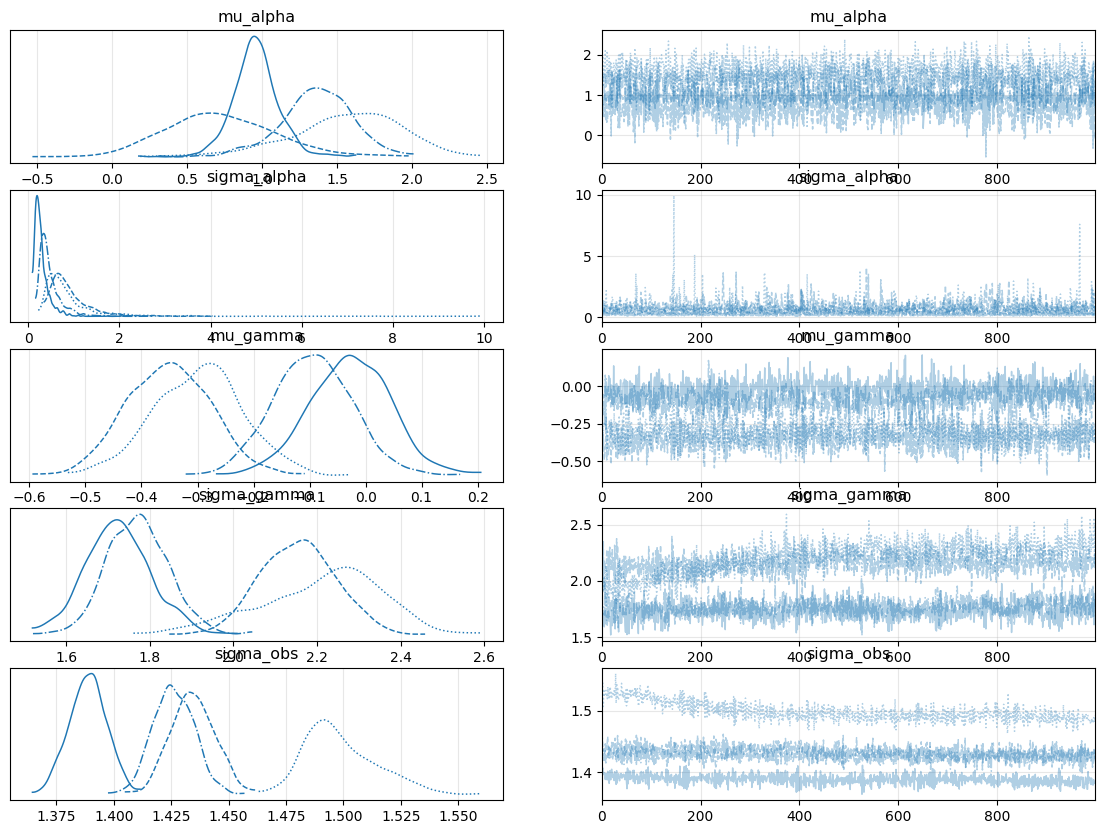

In [ ]:
# Plot trace diagnostics
fig = viz.plot_trace_diagnostics(model, figsize=(14, 10))
plt.show()

## Step 7: Extract Parameter Estimates

Get posterior means and credible intervals for all parameters.

In [ ]:
# Extract parameters
results = model.extract_parameters(hdi_prob=0.95)

# Print formatted summary
utils.print_model_summary(model, detailed=True)


Computing model fit statistics...
  Overall RMSE: 1.8060
  Overall MAE: 1.5718
  R²: 0.0176

MODEL SUMMARY: all_dark

DATA:
  Animals: 3
  Trials: 344
  Total timepoints: 65,702

POPULATION PARAMETERS:
  mu_alpha    :   0.005  95% HDI: [-0.042,  0.065]
  sigma_alpha :   0.030  95% HDI: [ 0.002,  0.116]
  mu_gamma    :   0.028  95% HDI: [ 0.012,  0.045]
  sigma_gamma :   0.077  95% HDI: [ 0.061,  0.092]
  mu_theta0   :   0.038  95% HDI: [ 0.004,  0.072]
  sigma_theta0:   0.174  95% HDI: [ 0.148,  0.202]
  sigma_obs   :   1.810  95% HDI: [ 1.801,  1.820]

MODEL FIT:
  R²: 0.018
  RMSE: 1.806
  MAE: 1.572

ANIMAL-SPECIFIC ALPHA:
  jp1686                   : -0.005  95% HDI: [-0.009, -0.001]
  jp3120                   :  0.005  95% HDI: [-0.001,  0.011]
  jp3269                   : -0.008  95% HDI: [-0.014, -0.002]


## Step 8: Visualize Parameter Estimates

### Population-Level Posterior Distributions

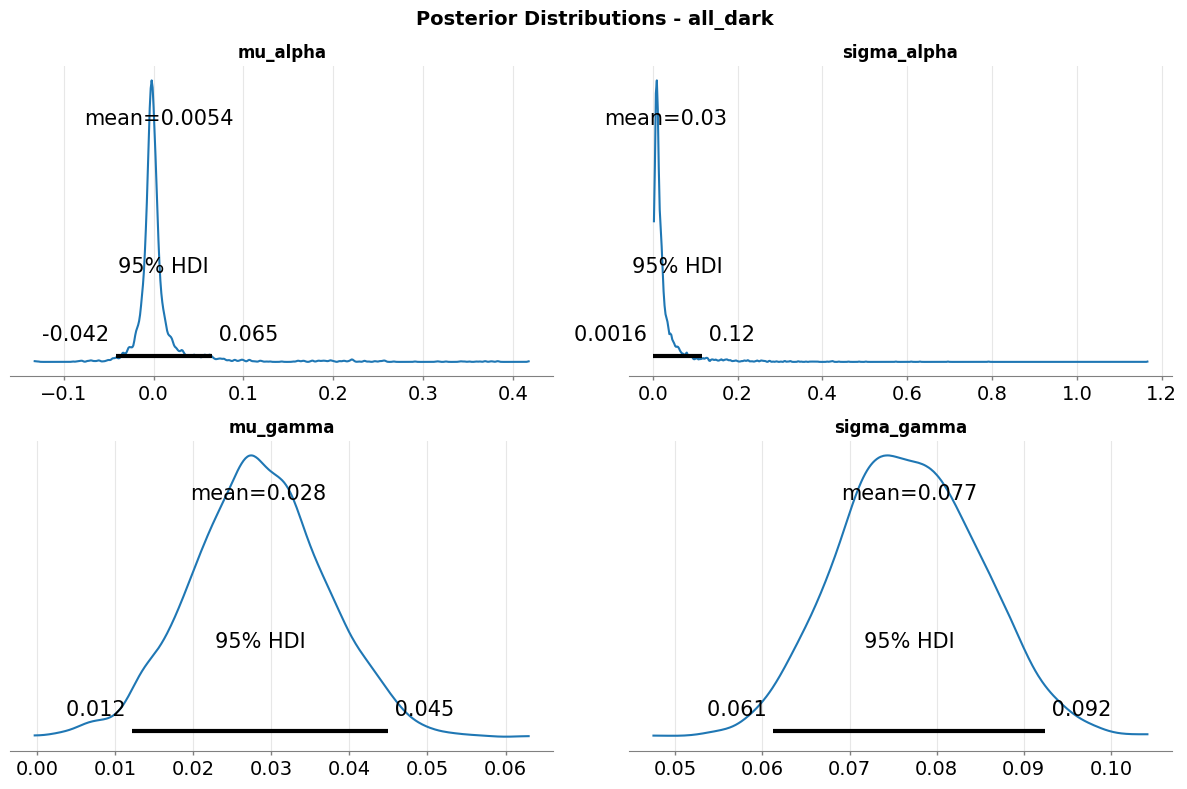

In [ ]:
# Plot posterior distributions
fig = viz.plot_posterior_distributions(model, figsize=(12, 8))
plt.show()

### Animal-Specific Alpha Estimates

Shows individual differences in gain parameter (integration ability).

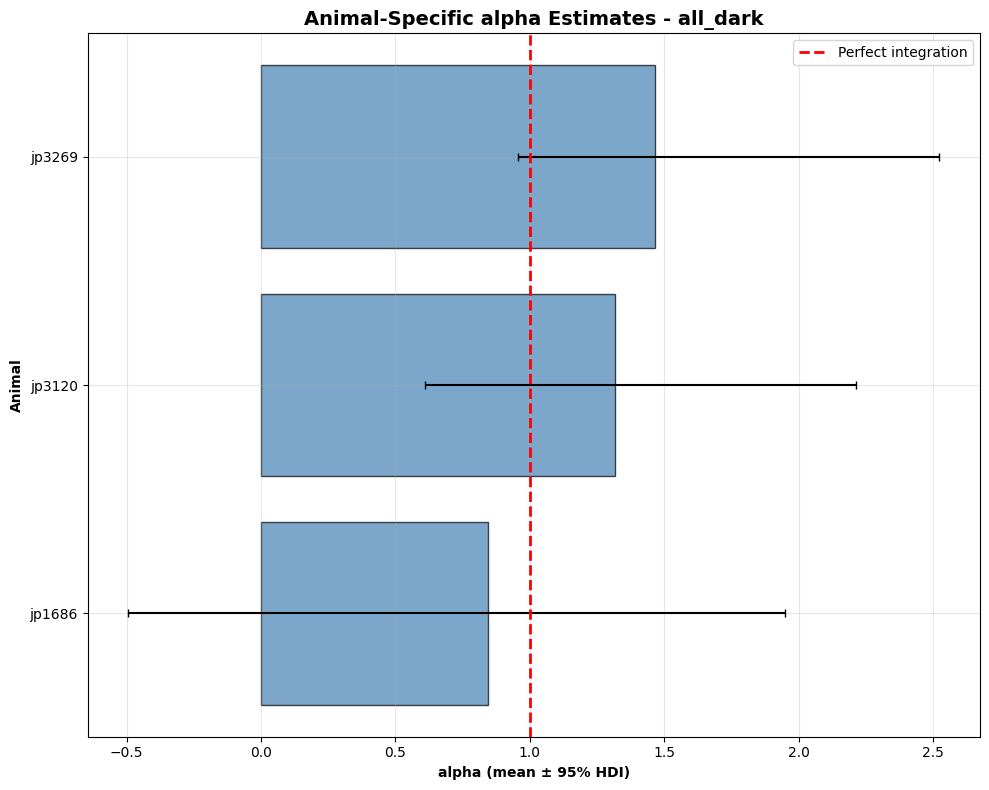

In [ ]:
# Plot animal-specific alphas
fig = viz.plot_animal_parameters(model, param='alpha', figsize=(10, 8))
plt.show()

## Step 9: Model Fit Quality

Visualize predicted vs. observed headings for random trials.

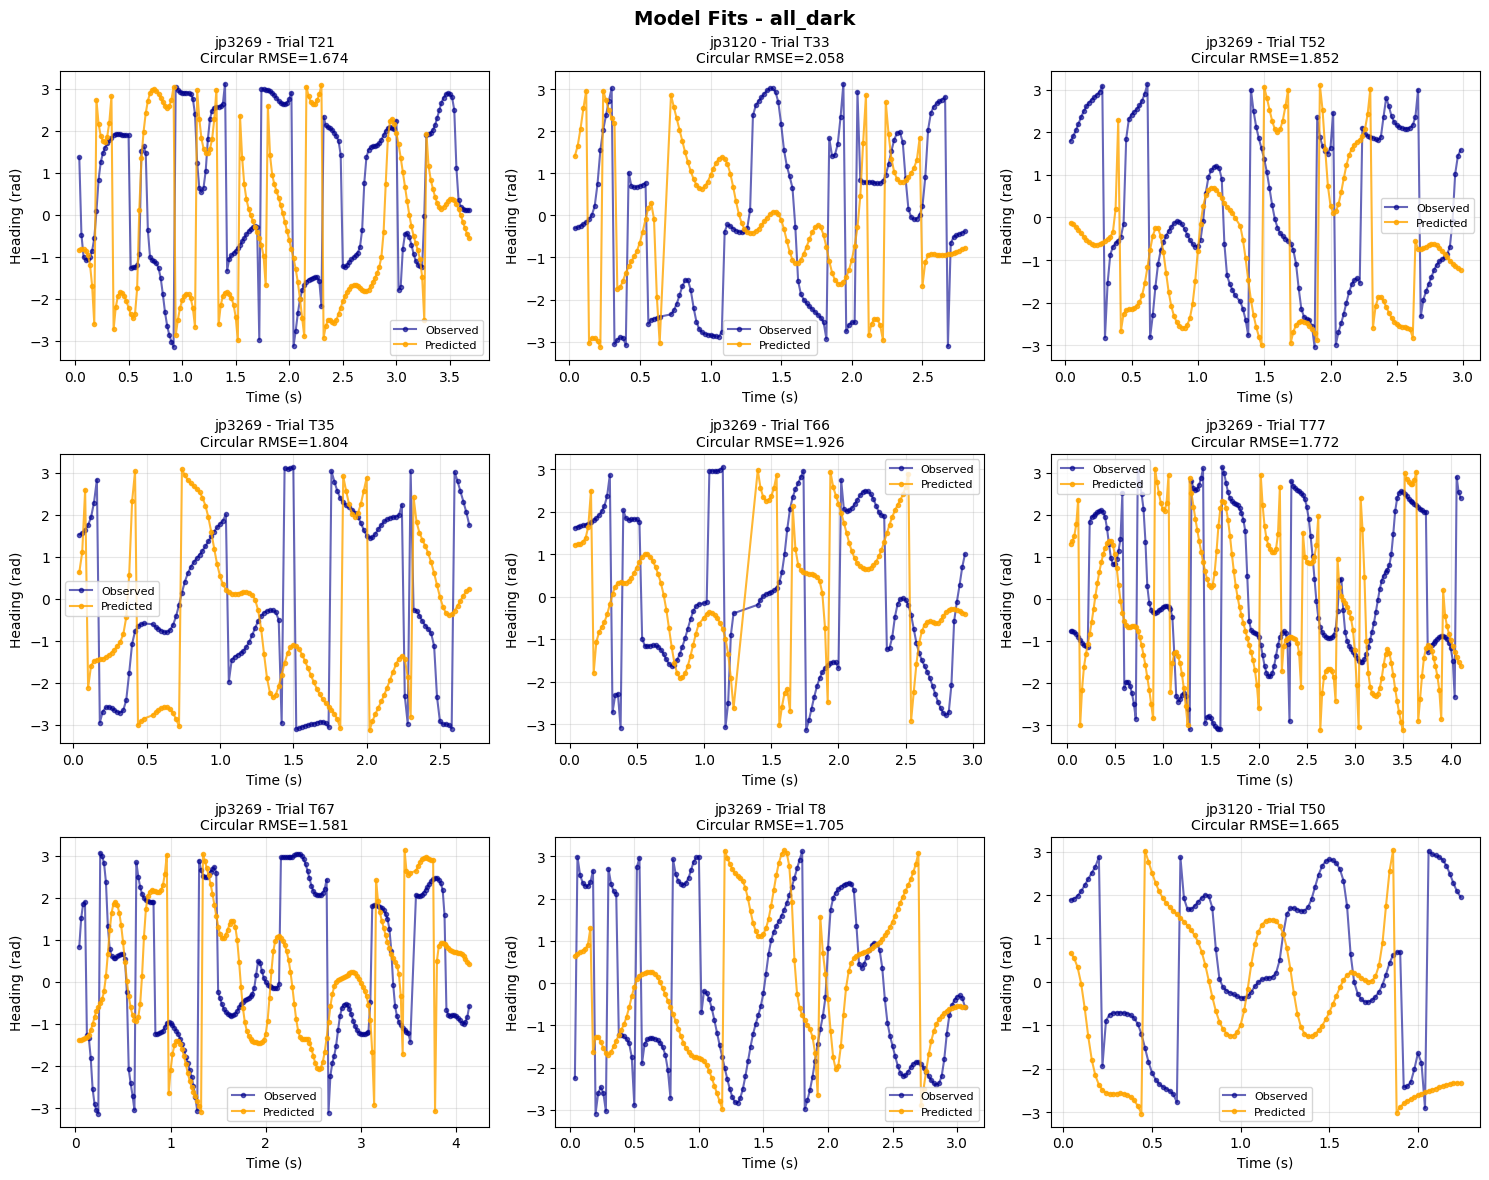

In [ ]:
import importlib
from heading_model import visualization as viz

importlib.reload(viz)
# Plot model fits for 9 random trials
fig = viz.plot_model_fits(model, n_trials=9, random_seed=42, figsize=(15, 12))
plt.show()

### Compute Fit Statistics

In [ ]:
# Compute model fit statistics
fit_stats = model.compute_model_fit_stats()

print("Overall Fit Statistics:")
print(f"  R²: {fit_stats['overall']['r_squared']:.3f}")
print(f"  RMSE: {fit_stats['overall']['rmse']:.3f} rad")
print(f"  MAE: {fit_stats['overall']['mae']:.3f} rad")

# Show trial-level statistics
print("\nTrial-level statistics (first 10):")
print(fit_stats['trials'].head(10))


Computing model fit statistics (circular residuals)...
  Overall RMSE (circular): 1.8043 rad
  Overall MAE (circular): 1.5611 rad
  R² (circular): -0.0591
Overall Fit Statistics:
  R²: -0.059
  RMSE: 1.804 rad
  MAE: 1.561 rad

Trial-level statistics (first 10):
   animal                 trial_id      rmse       mae  n_points
0  jp1686  jp1686-26042022-0108_T0  1.677315  1.399839       183
1  jp1686  jp1686-26042022-0108_T1  1.601149  1.403760       172
2  jp1686  jp1686-26042022-0108_T2  1.513648  1.175097       138
3  jp1686  jp1686-26042022-0108_T3  1.776368  1.557331       153
4  jp1686  jp1686-26042022-0108_T4  1.989602  1.811048       201
5  jp1686  jp1686-26042022-0108_T5  1.933107  1.726859       196
6  jp1686  jp1686-26042022-0108_T6  1.994495  1.754912       556
7  jp1686  jp1686-26042022-0108_T7  1.668431  1.422813       148
8  jp1686  jp1686-26042022-0108_T8  2.159493  1.947162       135
9  jp1686  jp1686-26042022-0108_T9  1.746697  1.493986       138


## Step 10: Posterior Predictive Checks

Generate predictions from posterior and compare to observed data.

In [ ]:
# Generate posterior predictive samples
ppc = model.posterior_predictive_check(n_samples=100)

# Plot posterior predictive checks
fig = viz.plot_posterior_predictive_checks(model, ppc, figsize=(12, 5))
plt.show()


Generating posterior predictive samples (n=100)...


TypeError: sample_posterior_predictive() got an unexpected keyword argument 'samples'

## Step 11: Export Results

Save parameter estimates and fit statistics to CSV files.

In [ ]:
# Export results
output_dir = '../../../Peng/results/heading_model/'
import os
os.makedirs(output_dir, exist_ok=True)

utils.export_results_to_csv(
    model,
    filename=os.path.join(output_dir, 'all_light'),
    include_trials=True
)

# Save model object
model.save(os.path.join(output_dir, 'all_light_model.pkl'))

: 

: 

: 

: 

: 

: 

## Step 12: Compare Multiple Conditions (Optional)

Fit models for different experimental conditions and compare parameters.

In [ ]:
# Fit models for multiple conditions
# WARNING: This will take a long time!
models = ca.fit_models_by_condition(
    conditions=['all_light', 'all_dark'],
    sessions=dp.DEFAULT_USEABLE_SESSIONS,
    max_animals=5,  # Limit for demo
    fit_kwargs={
        'draws': 1000,  # Fewer draws for speed
        'tune': 500,
        'chains': 2
    }
)

: 

: 

: 

: 

: 

: 

In [ ]:
# Compare conditions
comparison = ca.compare_conditions(models, param='alpha')
print("\nParameter comparison:")
print(comparison)

: 

: 

: 

: 

: 

: 

In [ ]:
# Plot comparison
fig = viz.plot_condition_comparison(models, param='mu_alpha', figsize=(10, 6))
plt.show()

: 

: 

: 

: 

: 

: 

In [ ]:
# Test for differences between conditions
differences = ca.compute_condition_differences(
    models,
    condition_pairs=[('all_light', 'all_dark')],
    param='mu_alpha'
)

print("\nCondition differences:")
print(differences)

: 

: 

: 

: 

: 

: 

## Summary

This notebook demonstrated:
1. ✅ Loading and preprocessing behavioral data
2. ✅ Structuring data for hierarchical model
3. ✅ Building PyMC model with appropriate priors
4. ✅ Fitting with MCMC and checking convergence
5. ✅ Extracting and visualizing parameter estimates
6. ✅ Assessing model fit quality
7. ✅ Comparing parameters across conditions

### Key Findings Template:
- **Population mean α**: [value] (95% HDI: [lower, upper])
  - Interpretation: Animals show [perfect/under/over]-integration of angular velocity
- **Between-animal variability (σ_α)**: [value]
  - Interpretation: [Small/Large] individual differences
- **Model fit (R²)**: [value]
  - Interpretation: Model explains [X]% of variance in decoded heading

### Next Steps:
- Fit models for all conditions
- Test specific hypotheses (e.g., light vs. dark, search vs. homing)
- Explore correlations with other behavioral measures
- Consider model extensions (e.g., time-varying drift)